# Отчет к лабораторной работе №3 "Изучение алгоритма классификации на основе метода линейного дискриминантного анализа"
# по курсу: «Методы и техника распознавания образов»
## Выполнил студент группы БМТ1-22М Колокольников Георгий

## Цель работы:
### Изучить основы применения метода линейного дискриминантного анализа для решения задач классификации.

## Задание 1. Определение байесовской ошибки классификации

0. Импортируем необходимые программные пакеты

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from math import sqrt, exp, pi
from scipy.stats import norm

1. Для двух классов выполнить расчет координат «идеального» проекционного вектора методом ЛДА. Условные вероятности данных в каждом из классов подчиняются двумерному нормальному распределению с параметрами:    
-первый класс: среднее значение = [1; 3], СКО = [0,7; 0,8], коэффициент корреляции = 0,2.    
-второй класс: среднее значение = [3;2], СКО = [0,3; 1,8], коэффициент корреляции = 0,7.   
При расчете принять априорные вероятности классов одинаковыми.


In [2]:
# First class parameters
mean_1 = np.array([1, 3]) # Mean value
std_1 = np.array([0.7, 0.8]) # Standard deviation
cor_coef_1 = 0.2 # Correlation coefficient
prob_1 = 0.5 # Class 1 prior probability
# Correlation matrix
sigma_1 = np.array([[std_1[0]**2, cor_coef_1*std_1[0]*std_1[1]],
                         [cor_coef_1*std_1[0]*std_1[1], std_1[1]**2]])


# Second class parameters
mean_2 = np.array([3, 2]) # Mean value
std_2 = np.array([0.3, 1.8]) # Standard deviation
cor_coef_2 = 0.7 # Correlation coefficient
prob_2 = 0.5 # Class 2 prior probability
# Correlation matrix
sigma_2 = np.array([[std_2[0]**2, cor_coef_2*std_2[0]*std_2[1]],
                         [cor_coef_2*std_2[0]*std_2[1], std_2[1]**2]])


# Within class difference matrix
Sw = 0.5*sigma_1 + 0.5*sigma_2

# Ideal projection vector
w_id = np.dot(np.linalg.inv(Sw),(mean_1 - mean_2))

In [3]:
sigma_2

array([[0.09 , 0.378],
       [0.378, 3.24 ]])

Получены координаты идеального вектора:

In [4]:
w_id

array([-8.20773019,  1.55200716])

2. Рассчитать байесовскую ошибку классификации. Для этого:  
-рассчитать параметры условных вероятностных распределений после проекции данных на «идеальный» проекционный вектор,   
-найти оптимальное пороговое значение для классификации,  
-найти вероятности ошибочной классификации в одну и другую стороны.

In [5]:
# Distribution parameters in the new space
mean_new_1 = np.dot(w_id.T, mean_1)
mean_new_2 = np.dot(w_id.T, mean_2)

sigma_new_1 = np.linalg.multi_dot([w_id.T, sigma_1, w_id])
sigma_new_2 = np.linalg.multi_dot([w_id.T, sigma_2, w_id])

Параметры условных вероятностных распределений после проекции данных на идеальный проекционный вектор:

In [6]:
print("Среднее значение для первого класса: %.2f" % mean_new_1,
      "\nСреднее значение для второго класса: %.2f" % mean_new_2,
      "\nСКО для первого класса: %.2f" % sigma_new_1,
      "\nСКО для второго класса: %.2f" % sigma_new_2)

Среднее значение для первого класса: -3.55 
Среднее значение для второго класса: -21.52 
СКО для первого класса: 31.70 
СКО для второго класса: 4.24


Найдем оптимальное пороговое значение для классификации, для чего зададим функционал на интервале [min(μ_1',μ_2');max(μ_1^,μ_2^) ]:  

In [7]:
def functional(y):
  return (prob_1*np.exp(-((y - mean_new_1)**2)/(2*sigma_new_1)))/np.sqrt(2*pi*sigma_new_1) - \
         (prob_2*np.exp(-((y - mean_new_2)**2)/(2*sigma_new_2)))/np.sqrt(2*pi*sigma_new_2)

min_point = min(mean_new_1, mean_new_2)
max_point = max(mean_new_1, mean_new_2)

In [8]:
y_thr = sci_opt.fsolve(functional, -10)

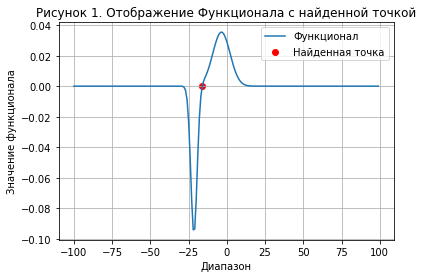

In [9]:
plt.plot(np.arange(-100, 100), functional(np.arange(-100, 100)), label="Функционал")
plt.scatter(y_thr[0], 0, c="r", label="Найденная точка")
plt.title("Рисунок 1. Отображение Функционала с найденной точкой")
plt.legend()
plt.xlabel("Диапазон")
plt.ylabel("Значение функционала")
plt.grid()
plt.show()

Найдем байесовскую ошибку попадания в интервал [Z2,Z1], где    
Zb1 - вероятность классификации граничного объекта в 1 класс,   
Zb2 - вероятность классификации граничного объекта во 2 класс.

In [10]:
Zb2 = (y_thr[0] - mean_new_2)/sqrt(sigma_new_2)
Zb1 = (y_thr[0] - mean_new_1)/sqrt(sigma_new_1)

Сложение площадей под кривыми нормального распределения соответственно правее и левее пороговой точки (оценка суммарной ошибки).

In [11]:
Err_b = 1 - norm.cdf(Zb2) + norm.cdf(Zb1)

Величина Байесовской ошибки классификации

In [12]:
print("Величина Байесовской ошибки классификации: %.2f" % Err_b)

Величина Байесовской ошибки классификации: 0.02


3. Построить зависимость вероятности ошибочной классификации от порогового значения. Убедиться, что байесовская ошибка является наименьшей возможной вероятностью ошибочной классификации.

Диапазон варьирования порога и шаг

In [13]:
min_point = min(mean_new_1, mean_new_2)
max_point = max(mean_new_1, mean_new_2)
step = 0.1
variation_range = np.arange(min_point, max_point, step)

Для удобства вычисления значений на каждой итерации напишем функции

In [14]:
def Zb1(ythr):
  return (ythr - mean_new_1)/sqrt(sigma_new_1)

def Zb2(ythr):
  return (ythr - mean_new_2)/sqrt(sigma_new_2)

def Err(ythr):
  return 1 - norm.cdf(Zb2(ythr)) + norm.cdf(Zb1(ythr))

Построим зависимость Err(y_thr)

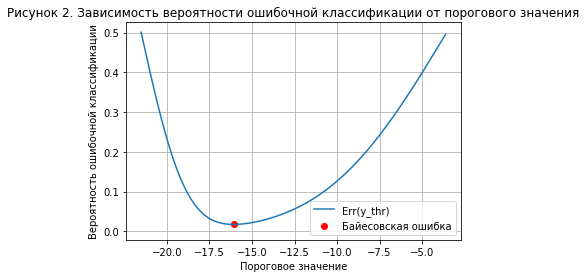

In [15]:
plt.scatter(y_thr[0], Err(y_thr[0]), c="r", label='Байесовская ошибка')
plt.plot(variation_range, Err(variation_range), label='Err(y_thr)')
plt.title("Рисунок 2. Зависимость вероятности ошибочной классификации от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("Вероятность ошибочной классификации")
plt.legend()
plt.grid()
plt.show()

Из рисунка 2 следует, что байесовская ошибка является наименьшей возможной вероятностью ошибочной классификации.

## Задание 2. Построение классификатора методом ЛДА

1. Для каждого из описанных в задании 1 классов сгенерировать по два набора данных: группу обучения и группу контроля. Общее число примеров обоих классов в группе обучения – 6000, в группе контроля – 2000. Принять оба класса равновероятными.

Параметры первого класса

In [50]:
# First class parameters
N_train = 200 # Number of samples in training set
N_test = 2000 # Number of samples in testing set
mean_1 = np.array([1, 3]) # Mean value
std_1 = np.array([0.7, 0.8]) # Standard deviation
cor_coef_1 = 0.2 # Correlation coefficient
prob_1 = 0.5 # Class 1 prior probability
# Correlation matrix
sigma_1 = np.array([[std_1[0]**2, cor_coef_1*std_1[0]*std_1[1]],
                         [cor_coef_1*std_1[0]*std_1[1], std_1[1]**2]])

Генерирование наборов данных

In [51]:
train_data_1 = np.random.multivariate_normal(mean_1, sigma_1, size=N_train)
test_data_1 = np.random.multivariate_normal(mean_1, sigma_1, size=N_test)

Параметры второго класса

In [52]:
# Second class parameters
N_train = 200 # Number of samples in training set
N_test = 2000 # Number of samples in testing set
mean_2 = np.array([3, 2]) # Mean value
std_2 = np.array([0.3, 1.8]) # Standard deviation
cor_coef_2 = 0.7 # Correlation coefficient
prob_2 = 0.5 # Class 2 prior probability
# Correlation matrix
sigma_2 = np.array([[std_2[0]**2, cor_coef_2*std_2[0]*std_2[1]],
                         [cor_coef_2*std_2[0]*std_2[1], std_2[1]**2]])

Генерирование наборов данных

In [53]:
train_data_2 = np.random.multivariate_normal(mean_2, sigma_2, size=N_train)
test_data_2 = np.random.multivariate_normal(mean_2, sigma_2, size=N_test)

In [54]:
train_data_2.shape

(200, 2)

Построим классы на плоскости исходного пространства

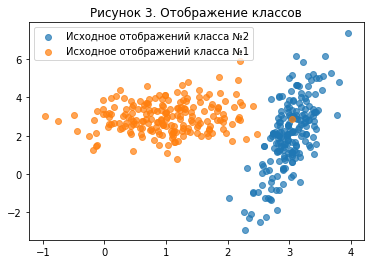

In [55]:
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.title("Рисунок 3. Отображение классов")
plt.legend()
plt.show()

2. По группе обучения выполнить расчет проекционного вектора методом ЛДА.

Расчет матриц внутриклассовых разбросов и общей матрицы внутриклассового разброса.

In [56]:
Sw1 = (N_train -1)*np.cov(train_data_1.T)
Sw2 = (N_train -1)*np.cov(train_data_2.T)
Sw = Sw1 + Sw2

Расчет вектора перехода

In [57]:
W = np.dot(np.linalg.inv(Sw),(mean_1 - mean_2).T)

Определение коэффициентов разделяющей прямой

In [58]:
Y1 = W.T*train_data_1
Y2 = W.T*train_data_2
b = W[1]/W[0]
X = np.append(train_data_1[:,0], train_data_2[:,0])
Y = np.append(train_data_1[:,1], train_data_2[:,1])
a = np.mean(Y) - b*np.mean(X)

Построение разделяющей прямой

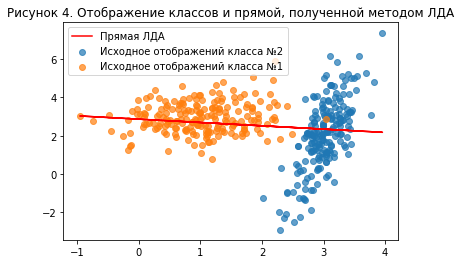

In [59]:
Y_devide = a+b*X
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.plot(X,Y_devide, label='Прямая ЛДА', c="r")
plt.title("Рисунок 4. Отображение классов и прямой, полученной методом ЛДА")
plt.legend()
plt.show()

3. Спроецировать данные из группы обучения на построенный вектор и определить пороговое значение, для которого суммарная частота ошибочной классификации будет минимальна.

Проекция данных в новое подпространство и расчет новых параметров распределения признаков

In [60]:
# Distribution parameters in the new space
mean_new_1 = np.dot(W.T, mean_1)
mean_new_2 = np.dot(W.T, mean_2)

sigma_new_1 = np.linalg.multi_dot([W.T, sigma_1, W])
sigma_new_2 = np.linalg.multi_dot([W.T, sigma_2, W])

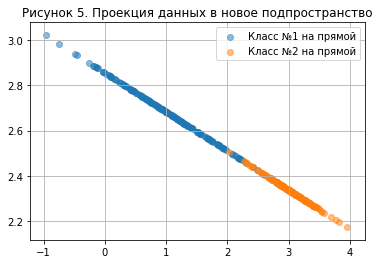

In [61]:
y1 = a+b*train_data_1[:,0]
y2 = a+b*train_data_2[:,0]

plt.scatter(train_data_1[:,0],y1, label='Класс №1 на прямой', alpha=0.5)
plt.scatter(train_data_2[:,0],y2, label='Класс №2 на прямой', alpha=0.5)
plt.title("Рисунок 5. Проекция данных в новое подпространство")
plt.legend()
plt.grid()
plt.show()

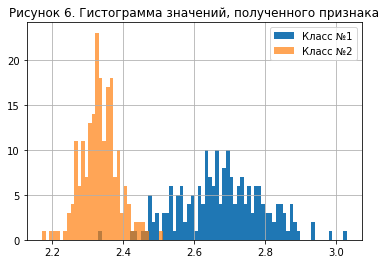

In [62]:
binwidth = 0.01
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс №1', alpha=1.0)
plt.hist(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth), label='Класс №2', alpha=0.7)
plt.title("Рисунок 6. Гистограмма значений, полученного признака")
plt.legend()
plt.grid()
plt.show()

Определим пороговое значение y_thr_new

In [63]:
# Calculate histograms
y1_hist = np.histogram(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth))
y2_hist = np.histogram(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth))

# Find peaks of histograms
y1_max = max(y1_hist[0])
y2_max = max(y2_hist[0])

# Find location of peaks
y1_max_coord = y1_hist[1][np.argwhere(y1_hist[0]==y1_max)[0][0]]
y2_max_coord = y2_hist[1][np.argwhere(y2_hist[0]==y2_max)[0][0]]

In [64]:
print("Максимальные значения на гистограмме:\nДля первого класса:", y1_max, " достигается при ", y1_max_coord,
      "\nДля второго класса:", y2_max, " достигается при ", y2_max_coord,)

Максимальные значения на гистограмме:
Для первого класса: 10  достигается при  2.62981706830839 
Для второго класса: 23  достигается при  2.3214858124624933


Создать набор порогов

In [65]:
threshold_range = np.arange(y2_max_coord, y1_max_coord, 0.01)

Функция для расчета суммарной частоты ошибочной классификации

In [66]:
def count_rel_error(hist_1, hist_2, thr):
  err_1 = np.sum(hist_1[0][np.nonzero(hist_1[1] < thr)[0]])
  err_2 = np.sum(hist_2[0][np.nonzero(hist_2[1] > thr)[0]-1])
  return (err_1+err_2)/(2*N_train)

In [67]:
error_range = np.array([count_rel_error(y1_hist, y2_hist, thr_x) for thr_x in threshold_range])
thr_new = threshold_range[np.argmin(error_range)]

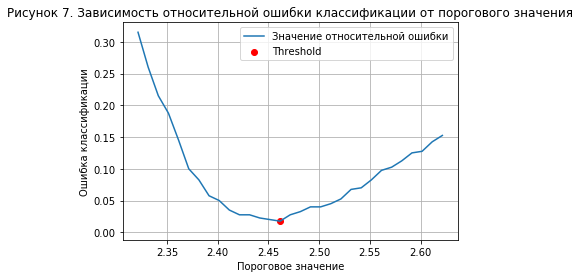

In [68]:
plt.scatter(thr_new, np.min(error_range), c="r", label='Threshold')
plt.plot(threshold_range, error_range, label='Значение относительной ошибки')
plt.title("Рисунок 7. Зависимость относительной ошибки классификации от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("Ошибка классификации")
plt.legend()
plt.grid()
plt.show()

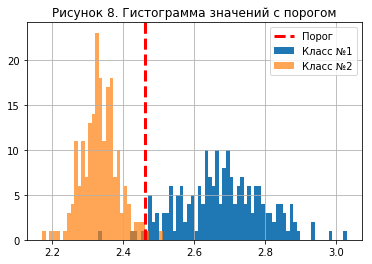

In [69]:
binwidth = 0.01
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс №1', alpha=1.0)
plt.hist(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth), label='Класс №2', alpha=0.7)
plt.axvline(thr_new, color='r', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Рисунок 8. Гистограмма значений с порогом")
plt.legend()
plt.grid()
plt.show()

In [70]:
print("Ошибка на тренировочной выборке составила: %.4f" % np.min(error_range))

Ошибка на тренировочной выборке составила: 0.0175


In [73]:
error_on_200 = np.min(error_range)

4. Рассчитать относительную частоту ошибочной классификации при применении построенного классификатора к группе контроля. 

Проекция тренирововочных данных

In [37]:
y1_test = a+b*test_data_1[:,0]
y2_test = a+b*test_data_2[:,0]

In [38]:
# Calculate histograms
y1_hist_test = np.histogram(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth))
y2_hist_test = np.histogram(y2_test, bins=np.arange(min(y2_test), max(y2_test) + binwidth, binwidth))

In [39]:
error_test = count_rel_error(y1_hist_test, y2_hist_test, thr_new)

In [40]:
print("Ошибка на тестовой выборке составила: %.2f" % error_test)

Ошибка на тестовой выборке составила: 0.01


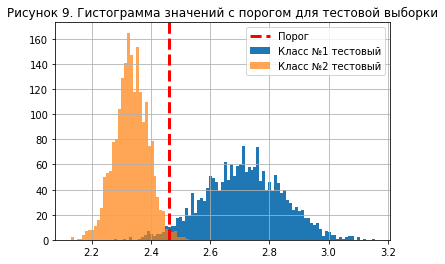

In [41]:
binwidth = 0.01
plt.hist(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth), label='Класс №1 тестовый', alpha=1.0)
plt.hist(y2_test, bins=np.arange(min(y2_test), max(y2_test) + binwidth, binwidth), label='Класс №2 тестовый', alpha=0.7)
plt.axvline(thr_new, color='r', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Рисунок 9. Гистограмма значений с порогом для тестовой выборки")
plt.legend()
plt.grid()
plt.show()

5. Рассчитать относительную частоту ошибочной классификации примеров группы контроля при использовании проекционного вектора и порогового значения, полученных ранее в задании 1. Сравнить полученные значения относительных частот ошибочной классификации.

In [42]:
# Distribution parameters in the ideal space
mean_id_1 = np.dot(w_id.T, mean_1)
mean_id_2 = np.dot(w_id.T, mean_2)

sigma_id_1 = np.linalg.multi_dot([w_id.T, sigma_1, w_id])
sigma_id_2 = np.linalg.multi_dot([w_id.T, sigma_2, w_id])

Построение разделяющей прямой по идеальному вектору

In [43]:
Y1_id = w_id.T*train_data_1
Y2_id = w_id.T*train_data_2
b_id = w_id[1]/w_id[0]
X_id = np.append(train_data_1[:,0], train_data_2[:,0])
Y_id = np.append(train_data_1[:,1], train_data_2[:,1])
a_id = np.mean(Y_id) - b*np.mean(X_id)
Y_devide_id = a_id+b_id*X_id
coeff = 18.55

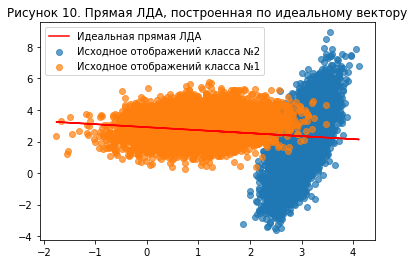

In [44]:
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.plot(X_id,Y_devide_id, label='Идеальная прямая ЛДА', c="r")
plt.title("Рисунок 10. Прямая ЛДА, построенная по идеальному вектору")
plt.legend()
plt.show()

In [45]:
y1_id = a_id+b_id*test_data_1[:,0]
y2_id = a_id+b_id*test_data_2[:,0]

In [46]:
# Calculate histograms
y1_hist_id = np.histogram(y1_id, bins=np.arange(min(y1_id), max(y1_id) + binwidth, binwidth))
y2_hist_id = np.histogram(y2_id, bins=np.arange(min(y2_id), max(y2_id) + binwidth, binwidth))
y_thr = y_thr[0]

In [47]:
error_id = count_rel_error(y1_hist_id, y2_hist_id, y_thr)
print("Ошибка на тестовой выборке составила: %.2f" % error_id)

Ошибка на тестовой выборке составила: 0.17


6. Повторить пп.1-5 для размера обучающей выборки 200. Сделать выводы.

In [75]:
print("Ошибка при меньшей выборке: %.4f" % error_on_200)

Ошибка при меньшей выборке: 0.0175


## Заключение

1. Байесовская ошибка классификации является наименьшей из возможных, что подтверждается построенной зависимостью вероятности ошибочной классификации от порогового значения.
2. Ошибка классификации при построеннии идеального вектора (в соответствии с байесовской ошибкой классификации) меньше, чем ошибка, полученная при построении проекционного вектора по обучающим данным.
3. С увеличением объема обучающей выборки точность классификации должна увеличиваться, при этом в случае тестирования на малой выборке, ошибка будет меньше, чем в случае тестирования на большой.